In [1]:
from torchvision import models, datasets, transforms
import torch
import torch.nn as nn
import numpy as np
from imp import reload
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter

from MN_Thesis_Package.NetworkClasses.Convolutional_Block_Networks import BlockNet, ResBlock, ConvBlock
from MN_Thesis_Package.utils.optimal_lr import lr_line_search
from MN_Thesis_Package.utils import gradient_memory_metrics as gm_metrics
from MN_Thesis_Package.utils import main_training_loop as train

In [2]:
# TODO: eliminate this transform and add batchnorm as the first layer for each network
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = datasets.CIFAR10('data/', download=True, transform=transform, train=True)
cifar10_test = datasets.CIFAR10('data/', download=True, transform=transform, train=False)

train_loader = torch.utils.data.DataLoader(cifar10_train,
                                           batch_size=128,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar10_test,
                                           batch_size=128,
                                           shuffle=True)

x_typical = None
for x_train, y_train in train_loader:
    x_typical = x_train.cuda(non_blocking=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
md = dict()
lossf = nn.NLLLoss()

input_channels = 3
hidden_layers = [64]*2 + [128]*2 + [256]*2 + [512]*2
n_classes = 10
block_type = ResBlock
objective_func = nn.LogSoftmax(dim=1)

model = BlockNet(input_channels, hidden_layers, n_classes, x_typical=x_typical, block_type=block_type, objective_func=objective_func)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.3)

Calculating loss over space 0-0.00154042 to check result of optimization package.


100%|██████████| 1540/1540 [12:57<00:00,  1.98it/s]

scipy.optimize.minimize was 99.99980524738933 more efficient than a naive test.


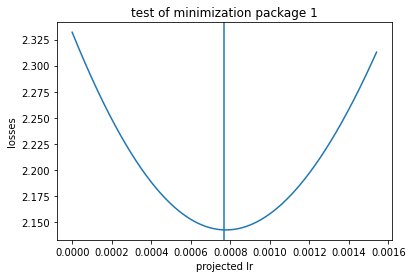

Calculating loss over space 0-0.00083717 to check result of optimization package.


100%|██████████| 837/837 [07:02<00:00,  1.98it/s]

scipy.optimize.minimize was 99.99964165069821 more efficient than a naive test.


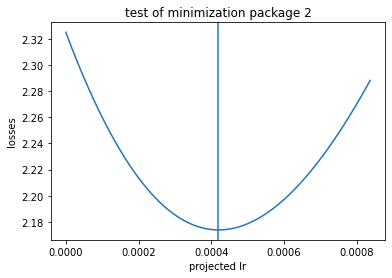

Calculating loss over space 0-0.00058091 to check result of optimization package.


100%|██████████| 580/580 [04:52<00:00,  1.98it/s]

scipy.optimize.minimize was 99.99948357167028 more efficient than a naive test.


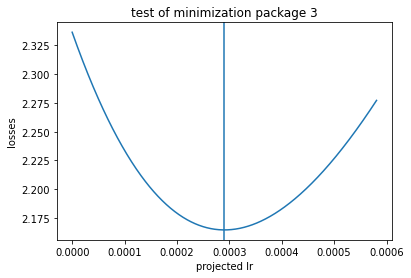

Calculating loss over space 0-0.0003004 to check result of optimization package.


100%|██████████| 300/300 [02:31<00:00,  1.98it/s]

scipy.optimize.minimize was 99.99900134494489 more efficient than a naive test.


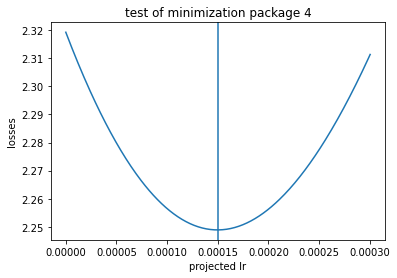

Calculating loss over space 0-0.00030368 to check result of optimization package.


100%|██████████| 303/303 [02:32<00:00,  1.98it/s]

scipy.optimize.minimize was 99.99901211905322 more efficient than a naive test.


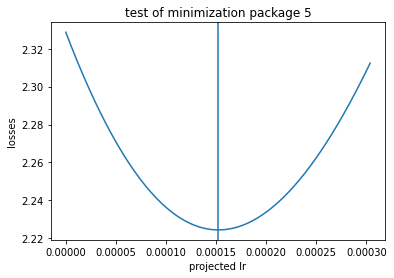

In [4]:
cases = 5
i = 0
for x_train, y_train in train_loader:
    x_train, y_train = x_train.cuda(non_blocking=True), y_train.cuda(non_blocking=True)


    # calculate and store training loss
    y_train_hat = model(x_train)
    loss_train = lossf(y_train_hat, y_train)

    # call .backward
    loss_train.backward()
    i += 1
    
    lr_tests, losses, optimal_lr = lr_line_search(model, lossf, x_train, y_train, test_run=True)
    
    plt.plot(lr_tests, losses)
    plt.axvline(x=optimal_lr)
    plt.ylabel('losses')
    plt.xlabel('projected lr')
    plt.title(f'test of minimization package {i}')
    plt.show()
    
    if i >= cases:
        break

# Full-Length Test

In [3]:
# the mask sizes (as a ratio) to test
mask_percentages = [.1]

# optimal lr parameters
max_lr=.1
optimal_lr_samples=50

# this determines how many vectors are used to calculate each gradient metric. 
# A list indicates we will take the metric multiple n_samples times for each number of vectors listed
n_vectors_RER=[5]
n_vectors_GD=[5]
n_vectors_GC=[2]

# these determine how many samples are taken for each gradient memory metric at initialization
n_frozen_samples_RER_init=0
n_frozen_samples_GD_init=0
n_frozen_samples_GC_init=0

# these determine how many frozen samples for each metric are taken each sample point during training
n_frozen_samples_RER=0
n_frozen_samples_GD=0
n_frozen_samples_GC=0

# this determines how many samples are averaged over in calculating each RER_normalizing constant
n_samples_normalizing_constant=10
RER_normalizing_constants_dict = torch.load('RER_constants.dt')

# This ratio dictates how frequently we have to store gradient memory vectors.
memory_sample_ratio = .2
sample_points_per_epoch = int(len(train_loader)/max(max(n_vectors_RER), max(n_vectors_GD), max(n_vectors_GC))*memory_sample_ratio)

# parameters controlling plotting and loss sampling frequency
graph_skip=50
tqdm_bool=True
plot_every=5

# parameters controlling specific layer sampling, which we will ignore initially
specific_layers=[]
only_specific_layers=False

epoch: 1, gradient metric samples: 0/15:   1%|          | 4/391 [00:02<03:16,  1.97it/s]/home/mvnelson422/LearnedOptimizer_clean_directory/MN_Thesis_Package/utils/optimal_lr.py:43: UserWarning: optimizer failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  warn(f'optimizer failed to converge: {res.message}')
epoch: 5, averaged loss: 0.560, accuracy: 70.67%: 100%|██████████| 391/391 [52:53<00:00,  8.12s/it]  


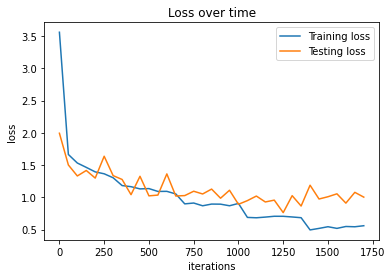

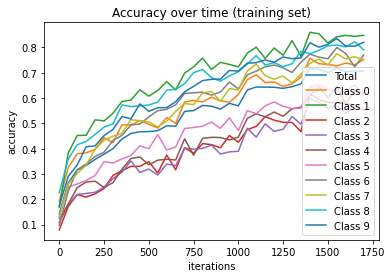

epoch: 6, gradient metric samples: 0/15:   1%|          | 4/391 [00:01<03:12,  2.01it/s]/home/mvnelson422/LearnedOptimizer_clean_directory/MN_Thesis_Package/utils/optimal_lr.py:43: UserWarning: optimizer failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  warn(f'optimizer failed to converge: {res.message}')
epoch: 9, averaged loss: 0.114, accuracy: 91.89%: 100%|██████████| 391/391 [1:01:22<00:00,  9.42s/it]
epoch: 10, averaged loss: 0.064, accuracy: 94.88%: 100%|██████████| 391/391 [1:11:13<00:00, 10.93s/it]  


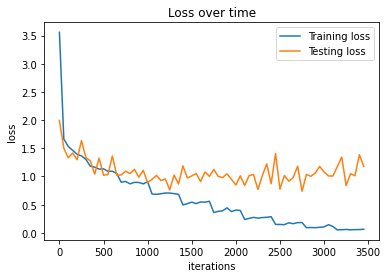

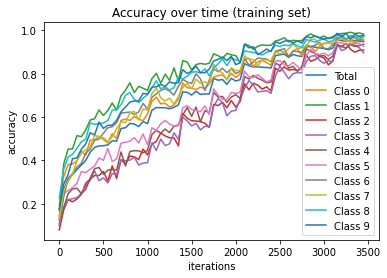

In [4]:
# begin or continue training of Res20 for # epochs
fileloc = './lr_optimization_tests/res20_1_50_lr_samples.pt'
epochs = 10

try:
    md = torch.load(fileloc)
    print(f"epochs previously completed: {md['epochs_completed']}")
    
except:
    md = dict()
    md['loss_func'] = nn.NLLLoss()

    md['input_classes'] = 3
    md['hidden_layers'] = [3] +  [64]*2 + [128]*2 + [256]*2 + [512]*3
    md['num_classes'] = 10
    md['block_type'] = ResBlock
    md['objective_func'] = nn.LogSoftmax(dim=1)

    md['model'] = BlockNet(md['input_classes'], md['hidden_layers'], md['num_classes'], x_typical=x_typical, block_type=md['block_type'], objective_func=md['objective_func'])
    md['model'].initialize_masks(mask_percentages)
    
    md['optimizer'] = torch.optim.SGD(md['model'].parameters(), lr=1e-2, momentum=0)
    md['lr_scheduler'] = torch.optim.lr_scheduler.StepLR(md['optimizer'], 20, gamma=0.3)
    
    
    # calculate gradient metrics at initialization
#     md['gradient_metrics'] = dict()
#     md['gradient_metrics']['epoch 0'] = gm_metrics.calculate_frozen_metrics(md['model'], train_loader, 
#                                                                  md['optimizer'], md['loss_func'], 
#                                                                  n_vectors_RER, n_vectors_GD, n_vectors_GC,
#                                                                  n_frozen_samples_RER_init, n_frozen_samples_GD_init,
#                                                                  n_frozen_samples_GC_init,
#                                                                  RER_normalizing_constants_dict, None,
#                                                                  specific_layers, only_specific_layers,
#                                                                  n_samples_normalizing_constant)
    
    
train.train(md, train_loader, test_loader, epochs,
            graph_skip=graph_skip, tqdm_bool=tqdm_bool, plot_every=plot_every,
            n_vectors_RER=n_vectors_RER, n_vectors_GD=n_vectors_GD, n_vectors_GC=n_vectors_GC,
            specific_layers=specific_layers, only_specific_layers=only_specific_layers,
            RER_normalizing_constants_dict=RER_normalizing_constants_dict, 
            n_samples_normalizing_constant=n_samples_normalizing_constant,
            sample_points_per_epoch=sample_points_per_epoch,
            n_frozen_samples_RER=n_frozen_samples_RER, n_frozen_samples_GD=n_frozen_samples_GD, 
            n_frozen_samples_GC=n_frozen_samples_GC,
            max_lr=max_lr, optimal_lr_samples=optimal_lr_samples)


# update permanent RER_constants dictionary
torch.save(RER_normalizing_constants_dict, 'RER_constants.dt')
# save out or update permanent results for this model
torch.save(md, fileloc)

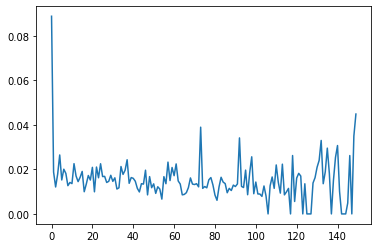

In [6]:
optimal_lrs = np.array([])
for i in range(1, 11):
    optimal_lrs = np.append(optimal_lrs, md['optimal_lrs'][f'epoch {i}'])
    
plt.plot(np.arange(len(optimal_lrs)), optimal_lrs)
plt.show()

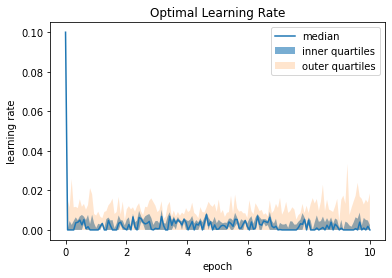

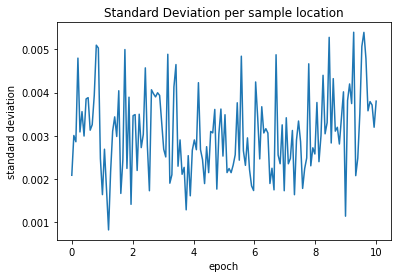

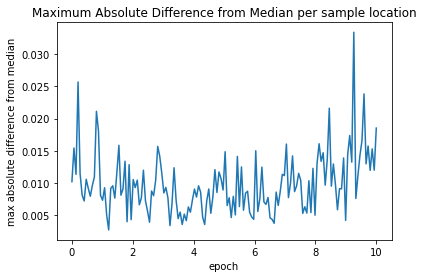

In [10]:
x = np.linspace(0, epochs, sample_points_per_epoch*epochs)
yq = np.zeros((5, len(x)))
stds = np.zeros(len(x))
max_dif_from_median = np.ones(len(x))

for epoch in range(1, 11):
    yq[:, (epoch-1)*sample_points_per_epoch: (epoch)*sample_points_per_epoch] = np.quantile(md['optimal_lrs'][f'epoch {epoch}'], [0.0, .25, .5, .75, 1.0] , axis=0)
    
    for i in range(np.shape(md['optimal_lrs'][f'epoch {epoch}'])[1]):
        stds[(epoch-1)*sample_points_per_epoch + i] = np.std(md['optimal_lrs'][f'epoch {epoch}'][:, i])
        max_dif_from_median[(epoch-1)*sample_points_per_epoch + i] = np.max(np.abs(np.median(md['optimal_lrs'][f'epoch {epoch}'][:, i]) - md['optimal_lrs'][f'epoch {epoch}'][:, i]))
        

fig, ax = plt.subplots()
ax.plot(x, yq[2, :], '-', label='median')
ax.fill_between(x, yq[1, :], yq[3, :], alpha=0.6, label='inner quartiles')
ax.fill_between(x, yq[0, :], yq[4, :], alpha=0.2, label='outer quartiles')
plt.title('Optimal Learning Rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(x, stds)
plt.title('Standard Deviation per sample location')
plt.xlabel('epoch')
plt.ylabel('standard deviation')
plt.show()

plt.plot(x, max_dif_from_median)
plt.title('Maximum Absolute Difference from Median per sample location')
plt.xlabel('epoch')
plt.ylabel('max absolute difference from median')
plt.show()